In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

from scipy.misc import imread
from collections import namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [2]:
# Load object to artist ID's mapping.
import json
o2a = open('oid_to_artist_id.json')
object_to_artists = json.load(o2a)
from utils.data_utils import *

In [3]:
# Image processing functions from 231N Assignment 3.
def preprocess(img, size=512):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    assert vnum >= 16, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

In [4]:
# Save default type for GPU.
dtype = torch.cuda.FloatTensor 
num_artists = 25

In [5]:
# Load pre-trained Squeezenet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# Freeze parameters to avoid computation time.
for param in cnn.parameters():
    param.requires_grad = False

In [6]:
# Assignment helper function that takes an image minibatch and model and returns a list of feature maps.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Variable of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Variable of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

In [7]:
# Style criterion and classifier.
style_criterion = nn.CrossEntropyLoss()
#style_classifier = nn.Linear(1548992, num_artists).cuda()
style_classifier = nn.Sequential(
        nn.Dropout(),
        #nn.Linear(1548992, 256),
        nn.Linear(186624, num_artists),
        #nn.ReLU(inplace=True),
        #nn.Dropout(),
        #nn.Linear(256,num_artists)
    ).cuda()
style_optimizer = torch.optim.Adam(style_classifier.parameters(), lr=1e-3)


In [8]:
# Content criterion and classifier.
content_criterion = nn.CrossEntropyLoss()
# content_classifier = nn.Linear(387200, num_artists).cuda()
content_classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(387200, num_artists)
    ).cuda()
content_optimizer = torch.optim.Adam(content_classifier.parameters(), lr = 1e-3)

In [9]:
# Helper function to run a single epoch of a model.
def run_style_epoch(object_to_artists):
    style_train_losses = []
    
    train_path = 'data/train/'
    train_batch_gen = batch_generator(train_path)
    # Store indices for style layers and content layer.
    #style_layers = [1, 4, 6, 7]
    style_layers = [7]
    
    # Load each batch of training data.
    style_train_loss = 0
    batch_counter = 0
    
    # Freeze CNN parameters.
    for param in cnn.parameters():
        param.requires_grad = False
        
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(train_batch_gen)
            X, Y = get_array_from_batch(train_path, current_batch, object_to_artists)
            
            # Store next batch as Torch Variables.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y)).type(torch.cuda.LongTensor)
            
            
            # Extract relevant features of CNN.
            all_features = extract_features(batch_input_var_pre, cnn)
            
            style_features_list = []
            for idx in style_layers:
                style_feats_curr = all_features[idx].clone()
                style_feats_curr = style_feats_curr.view(style_feats_curr.size(0), -1) # Flatten current ones
                style_features_list.append(style_feats_curr)
                
            style_features = torch.cat(tuple(style_features_list), 1).cuda()
            
            # Style: forward.
            style_optimizer.zero_grad()
            style_output = style_classifier(style_features)
            style_loss = style_criterion(style_output, batch_target_var)
            
            # Style: backward.
            style_loss.backward()
            style_optimizer.step()
            curr_style_loss = style_loss.data[0]
            style_train_loss += curr_style_loss
        
            
            # Print loss.
            batch_counter += 1
            print_count = 50  
            
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                print('[%5d] Style train loss: %.3f' % (batch_counter, style_train_loss / print_count))
                style_train_losses.append(style_train_loss/print_count)
                style_train_loss = 0

    except StopIteration:
        pass
    
    # Load validation data.
    val_path = 'data/val/'
    val_batch_gen = batch_generator(val_path)
    style_val_losses, content_val_losses = [], []
    style_val_loss, content_val_loss = 0, 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(val_batch_gen)
            X, Y = get_array_from_batch(val_path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Extract relevant features of CNN.
            all_features = extract_features(batch_input_var_pre, cnn)
            
            style_features_list = []
            for idx in style_layers:
                style_feats_curr = all_features[idx].clone()
                style_feats_curr = style_feats_curr.view(style_feats_curr.size(0), -1) # Flatten current ones
                style_features_list.append(style_feats_curr)
                
            style_features = torch.cat(tuple(style_features_list), 1).cuda()
            
            # Style: forward.
            style_optimizer.zero_grad()
            style_output = style_classifier(style_features)
            style_loss = style_criterion(style_output, batch_target_var)
            style_val_loss += style_loss.data[0]
            
            # Print loss.
            batch_counter += 1
            print_count = 8
            
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                print('[%5d] Style val loss: %.3f' % (batch_counter, style_val_loss / print_count))
                style_val_losses.append(style_val_loss/print_count)
                style_val_loss = 0
                      
    except StopIteration:
        pass
    
    return style_train_losses, style_val_losses

In [10]:
# Helper function to run a single epoch of a model.
def run_content_epoch(object_to_artists):
    content_train_losses = []
    
    train_path = 'data/train/'
    train_batch_gen = batch_generator(train_path)
    # Store indices for style layers and content layer.
    content_layer = 3
    
    # Load each batch of training data.
    content_train_loss = 0
    batch_counter = 0
    
    # Freeze CNN parameters.
    for param in cnn.parameters():
        param.requires_grad = False
        
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(train_batch_gen)
            X, Y = get_array_from_batch(train_path, current_batch, object_to_artists)
            
            # Store next batch as Torch Variables.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y)).type(torch.cuda.LongTensor)
            
            
            # Extract relevant features of CNN.
            all_features = extract_features(batch_input_var_pre, cnn)
            content_features = all_features[content_layer].clone()
            content_features = content_features.view(content_features.size(0), -1).cuda() # Flatten content features

            # Content: forward.
            content_optimizer.zero_grad()
            content_output = content_classifier(content_features)
            content_loss = content_criterion(content_output, batch_target_var)
            
            # Content: backward.
            content_loss.backward()
            content_optimizer.step()
            curr_content_loss = content_loss.data[0]
            content_train_loss += curr_content_loss
            
            # Print loss.
            batch_counter += 1
            print_count = 50  
            
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                print('[%5d] Content train loss: %.3f' % (batch_counter, content_train_loss / print_count))
                content_train_losses.append(content_train_loss/print_count)
                content_train_loss = 0
                

    except StopIteration:
        pass
    
    # Load validation data.
    val_path = 'data/val/'
    val_batch_gen = batch_generator(val_path)
    content_val_losses = []
    content_val_loss = 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(val_batch_gen)
            X, Y = get_array_from_batch(val_path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Extract relevant features of CNN.
            all_features = extract_features(batch_input_var_pre, cnn)
            content_features = all_features[content_layer].clone()
            content_features = content_features.view(content_features.size(0), -1).cuda() # Flatten content features
            
            # Content: forward.
            content_optimizer.zero_grad()
            content_output = content_classifier(content_features)
            content_loss = content_criterion(content_output, batch_target_var)

            content_val_loss += content_loss.data[0]
            
            # Print loss.
            batch_counter += 1
            print_count = 8
            
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                
                print('[%5d] Content val loss: %.3f' % (batch_counter, content_val_loss / print_count))
                content_val_losses.append(content_val_loss/print_count)
                content_val_loss = 0
                      
    except StopIteration:
        pass
    
    return content_train_losses, content_val_losses

In [11]:
cnn_criterion = nn.CrossEntropyLoss()

In [12]:
# Helper function to run a single epoch of a model.
def run_content_retrain_epoch(object_to_artists):
    retrain_content_train_losses = []
    
    train_path = 'data/train/'
    train_batch_gen = batch_generator(train_path)
    # Store indices for style layers and content layer.
    content_layer = 3
    
    # Load each batch of training data.
    retrain_content_train_loss = 0
    batch_counter = 0
    
    # Retrain CNN and test classification.
    for param in cnn.parameters():
        param.requires_grad = True
    
    cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-5)
    
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(train_batch_gen)
            X, Y = get_array_from_batch(train_path, current_batch, object_to_artists)
            
            # Store next batch as Torch Variables.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y)).type(torch.cuda.LongTensor)
            
#             # Extract relevant features of CNN.
            
#             all_features = extract_features(batch_input_var_pre, cnn)
#             content_features = all_features[content_layer].clone()
#             content_features = content_features.view(content_features.size(0), -1).cuda() # Flatten content features

            # CNN forward pass.
            cnn_optimizer.zero_grad()
            cnn_output = cnn(batch_input_var_pre)
            cnn_output = cnn_output.view(cnn_output.size(0), -1)
            batch_loss = cnn_criterion(cnn_output, batch_target_var)
            
            # CNN backward pass.
            batch_loss.backward()
            cnn_optimizer.step()
            retrain_content_train_loss += batch_loss.data[0]
            
            # Print loss.
            batch_counter += 1
            print_count = 50  
            
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                print('[%5d] Content train loss: %.3f' % (batch_counter, retrain_content_train_loss / print_count))
                retrain_content_train_losses.append(retrain_content_train_loss/print_count)
                retrain_content_train_loss = 0
                

    except StopIteration:
        pass
    
    # Load validation data.
    val_path = 'data/val/'
    val_batch_gen = batch_generator(val_path)
    retrain_content_val_losses = []
    retrain_content_val_loss = 0
    batch_counter = 0
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(val_batch_gen)
            X, Y = get_array_from_batch(val_path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), requires_grad=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            cnn.eval() 

            # CNN forward pass.
            cnn_optimizer.zero_grad()
            cnn_output = cnn(batch_input_var_pre)
            cnn_output = cnn_output.view(cnn_output.size(0), -1)
            batch_loss = cnn_criterion(cnn_output, batch_target_var)
            
            retrain_content_val_loss += batch_loss.data[0]
            
            # Print loss.
            batch_counter += 1
            print_count = 8
            
            if batch_counter % print_count == 0: # Print avg batch loss, every 100 mini-batches. Zero out.
                
                print('[%5d] Content val loss: %.3f' % (batch_counter, retrain_content_val_loss / print_count))
                retrain_content_val_losses.append(retrain_content_val_loss/print_count)
                retrain_content_val_loss = 0
                      
    except StopIteration:
        pass
    
    return retrain_content_train_losses, retrain_content_val_losses

In [13]:
def compute_style_accuracy(atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    num_predictions = 0
    num_correct_predictions = 0
    batch_size = 50
    batch_counter = 0
    train_batches = 100

    # style_layers = [1, 4, 6, 7]
    style_layers = [7]
    
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make content predictions
            all_features = extract_features(batch_input_var_pre, cnn)
            
            style_features_list = []
            for idx in style_layers:
                style_feats_curr = all_features[idx].clone()
                style_feats_curr = style_feats_curr.view(style_feats_curr.size(0), -1) # Flatten current ones
                style_features_list.append(style_feats_curr)
                
            style_features = torch.cat(tuple(style_features_list), 1).cuda()
            
            style_output = style_classifier(style_features)
            predictions = torch.max(style_output, 1)[1]
            
            # Check accuracy
            num_predictions += 50
            num_correct_predictions += torch.sum(torch.eq(predictions, batch_target_var)).data[0]
            
            batch_counter += 1
            if batch_counter == train_batches and atype == 'train':
                raise(StopIteration)
            
                      
    except StopIteration:
        accuracy = float(num_correct_predictions) / num_predictions
        print(atype + ' accuracy: ' + str(accuracy))

In [14]:
def compute_content_accuracy(atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    num_predictions = 0
    num_correct_predictions = 0
    batch_size = 50
    batch_counter = 0
    train_batches = 100

    content_layer = 3
    
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make content predictions
            all_features = extract_features(batch_input_var_pre, cnn)
            content_features = all_features[content_layer].clone()
            content_features = content_features.view(content_features.size(0), -1).cuda() # Flatten content features
            
            content_output = content_classifier(content_features)
            predictions = torch.max(content_output, 1)[1]
            
            # Check accuracy
            num_predictions += 50
            num_correct_predictions += torch.sum(torch.eq(predictions, batch_target_var)).data[0]
            
            batch_counter += 1
            if batch_counter == train_batches and atype == 'train':
                raise(StopIteration)
            
                      
    except StopIteration:
        accuracy = float(num_correct_predictions) / num_predictions
        print(atype + ' accuracy: ' + str(accuracy))

In [ ]:
# Apply content classifier.
new_classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, num_artists, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(13)
).cuda()

content_train_losses, content_val_losses = [], []
retrain_content_train_losses, retrain_content_val_losses = [], []

content_optimizer = torch.optim.Adam(content_classifier.parameters(), lr = 1e-3)

for j in range(5):
    content_optimizer = torch.optim.Adam(content_classifier.parameters(), lr = 1e-3)
    for i in range(5):
        print('Epoch: ' + str(i+1))
        curr_content_tl, curr_content_vl = run_content_epoch(object_to_artists)
        content_train_losses += curr_content_tl
        content_val_losses += curr_content_vl
        compute_content_accuracy('train', object_to_artists)
        compute_content_accuracy('test', object_to_artists)

    # Retrain CNN and test classification.
    cnn.classifier = new_classifier
    for param in cnn.parameters():
        param.requires_grad = True
    
    content_optimizer = torch.optim.Adam(content_classifier.parameters(), lr = 1e-4)
    print('Starting Retraining Cycle.')

    for i in range(5):
        curr_content_tl, curr_content_vl = run_content_retrain_epoch(object_to_artists)
        retrain_content_train_losses += curr_content_tl
        retrain_content_val_losses += curr_content_vl

        compute_content_accuracy('train', object_to_artists)
        compute_content_accuracy('test', object_to_artists)

In [ ]:
def generate_content_predictions(n_batches, atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    
    all_predictions = np.zeros((50 * n_batches))
    all_labels = np.zeros((50 * n_batches))
    batch_counter = 0
    
    content_layer = 3
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make predictions
#             batch_output = model(batch_input_var_pre)
            
            # Make content predictions
            all_features = extract_features(batch_input_var_pre, cnn)
            content_features = all_features[content_layer].clone()
            content_features = content_features.view(content_features.size(0), -1).cuda() # Flatten content features
            
            content_output = content_classifier(content_features)
            
            predictions = torch.max(content_output, 1)[1]
            predictions = predictions.view(predictions.size(0))
            start = batch_counter * 50
            all_predictions[start:start + 50] = predictions.data.cpu().numpy()
            all_labels[start:start + 50] = Y
            
            batch_counter += 1
            if batch_counter == n_batches:
                raise(StopIteration)
                      
    except StopIteration:
        pass
    
    return all_predictions, all_labels

In [ ]:
import matplotlib.ticker as ticker

def plot_content_confusion_matrix(n_categories, n_batches, atype, object_to_artists):
    confusion = torch.zeros(n_categories, n_categories)
    
    predictions, labels = generate_content_predictions(n_batches, atype, object_to_artists)
    
    for i in range(predictions.shape[0]):
        prediction = predictions[i]
        label = labels[i]
        confusion[label][prediction] += 1
    
    
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax, cmap='jet')

    # Set up axes
    all_categories = ['Jan Luyken',
        'George Breitner',
        'Reinier Vinkeles',
        'Marius Bauer',
        'Isaac Israels',
        'Willem Witsen',
        'Daniel Chodowiecki',
        'Bernard Picart',
        'Rembrandt van Rijn',
        'Jacob Houbraken',
        'Antonio Tempesta',
        'Johannes Tavenraat',
        'Wenceslaus Hollar',
        'Simon Fokke',
        'Carel Cachet',
        'Jacob de Gheyn (II)',
        'Romeyn de Hooghe',
        'Meissener Manufaktur',
        'Jacques Callot',
        'Johann Sadeler (I)',
        'Jozef Israels',
        'Frans Hogenberg',
        'Crispijn van de Passe',
        'Jan van de Velde (II)',
        'Virgilius Solis (I)']
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


In [ ]:
plot_content_confusion_matrix(25, 100, 'test', object_to_artists)

In [15]:
# Apply style classifier.
new_classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, num_artists, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(13)
).cuda()

style_train_losses, style_val_losses = [], []
retrain_style_train_losses, retrain_style_val_losses = [], []

style_optimizer = torch.optim.Adam(style_classifier.parameters(), lr = 1e-3)

for j in range(5):
    print('Retraining Linear Layers, Cycle ' + str(j+1))
    style_optimizer = torch.optim.Adam(style_classifier.parameters(), lr = 1e-3)
    for i in range(5):
        print('Epoch: ' + str(i+1))
        curr_style_tl, curr_style_vl = run_style_epoch(object_to_artists)
        style_train_losses += curr_style_tl
        style_val_losses += curr_style_vl
        compute_style_accuracy('train', object_to_artists)
        compute_style_accuracy('test', object_to_artists)

    # Retrain CNN and test classification.
    cnn.classifier = new_classifier
    for param in cnn.parameters():
        param.requires_grad = True
    
    style_optimizer = torch.optim.Adam(style_classifier.parameters(), lr = 1e-4)
    print('Starting Retraining Cycle ' + str(j+1))

    for i in range(5):
        curr_style_tl, curr_style_vl = run_content_retrain_epoch(object_to_artists)
        retrain_style_train_losses += curr_style_tl
        retrain_style_val_losses += curr_style_vl

        compute_style_accuracy('train', object_to_artists)
        compute_style_accuracy('test', object_to_artists)

Retraining Linear Layers, Cycle 1
Epoch: 1
[   50] Style train loss: 541.712
[  100] Style train loss: 328.861
[  150] Style train loss: 259.758
[    8] Style val loss: 240.804
[   16] Style val loss: 224.291
[   24] Style val loss: 256.082
train accuracy: 0.5752
test accuracy: 0.44456140350877194
Epoch: 2
[   50] Style train loss: 133.878
[  100] Style train loss: 155.840
[  150] Style train loss: 138.640
[    8] Style val loss: 205.259
[   16] Style val loss: 203.488
[   24] Style val loss: 194.102
train accuracy: 0.703
test accuracy: 0.5196491228070176
Epoch: 3
[   50] Style train loss: 70.195
[  100] Style train loss: 88.384
[  150] Style train loss: 70.101
[    8] Style val loss: 151.810
[   16] Style val loss: 163.295
[   24] Style val loss: 180.768
train accuracy: 0.793
test accuracy: 0.5185964912280702
Epoch: 4
[   50] Style train loss: 54.655
[  100] Style train loss: 65.210
[  150] Style train loss: 59.867
[    8] Style val loss: 198.622
[   16] Style val loss: 191.006
[   24

In [16]:
# Generate style predictions
def generate_style_predictions(n_batches, atype, object_to_artists):
    path = 'data/' + atype 
    batch_gen = batch_generator(path)
    
    all_predictions = np.zeros((50 * n_batches))
    all_labels = np.zeros((50 * n_batches))
    batch_counter = 0
    
    # content_layer = 3
    style_layer = 7
    try:
        while True:
            # Load next batch as NP arrays.
            current_batch = next(batch_gen)
            X, Y = get_array_from_batch(path, current_batch, object_to_artists)
            
            # Forward pass.
            batch_input_var = torch.autograd.Variable(torch.from_numpy(X), volatile=True).type(torch.cuda.FloatTensor)
            preprocessor = torch.nn.BatchNorm2d(3).cuda()
            batch_input_pre = preprocessor(batch_input_var)
            batch_input_var_pre = torch.autograd.Variable(batch_input_pre.data, requires_grad=True).type(torch.cuda.FloatTensor)
            
            batch_target_var = torch.autograd.Variable(torch.from_numpy(Y), volatile=True).type(torch.cuda.LongTensor)
            
            # Make predictions
#             batch_output = model(batch_input_var_pre)
            
            # Make content predictions
            all_features = extract_features(batch_input_var_pre, cnn)
            style_features = all_features[style_layer].clone()
            style_features = style_features.view(style_features.size(0), -1).cuda() # Flatten style features
            
            style_output = style_classifier(style_features)
            
            predictions = torch.max(style_output, 1)[1]
            predictions = predictions.view(predictions.size(0))
            start = batch_counter * 50
            all_predictions[start:start + 50] = predictions.data.cpu().numpy()
            all_labels[start:start + 50] = Y
            
            batch_counter += 1
            if batch_counter == n_batches:
                raise(StopIteration)
                      
    except StopIteration:
        pass
    
    return all_predictions, all_labels

In [17]:
import matplotlib.ticker as ticker

def plot_style_confusion_matrix(n_categories, n_batches, atype, object_to_artists):
    confusion = torch.zeros(n_categories, n_categories)
    
    predictions, labels = generate_style_predictions(n_batches, atype, object_to_artists)
    
    for i in range(predictions.shape[0]):
        prediction = predictions[i]
        label = labels[i]
        confusion[label][prediction] += 1
    
    
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax, cmap='jet')

    # Set up axes
    all_categories = ['Jan Luyken',
        'George Breitner',
        'Reinier Vinkeles',
        'Marius Bauer',
        'Isaac Israels',
        'Willem Witsen',
        'Daniel Chodowiecki',
        'Bernard Picart',
        'Rembrandt van Rijn',
        'Jacob Houbraken',
        'Antonio Tempesta',
        'Johannes Tavenraat',
        'Wenceslaus Hollar',
        'Simon Fokke',
        'Carel Cachet',
        'Jacob de Gheyn (II)',
        'Romeyn de Hooghe',
        'Meissener Manufaktur',
        'Jacques Callot',
        'Johann Sadeler (I)',
        'Jozef Israels',
        'Frans Hogenberg',
        'Crispijn van de Passe',
        'Jan van de Velde (II)',
        'Virgilius Solis (I)']
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


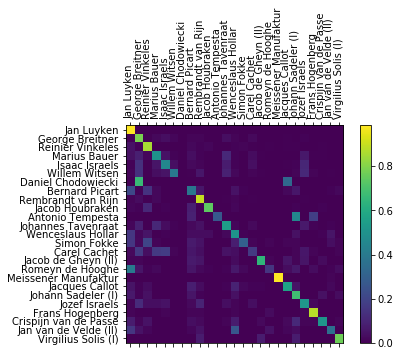

In [18]:
plot_style_confusion_matrix(25, 100, 'test', object_to_artists)

In [ ]:
# Apply style classifier.
style_train_losses, style_val_losses = [], []
for i in range(5):
    print('Epoch: ' + str(i+1))
    curr_style_tl, curr_style_vl = run_content_epoch(object_to_artists)
    style_train_losses += curr_style_tl
    style_val_losses += curr_style_vl
    compute_content_accuracy('train', object_to_artists)
    compute_content_accuracy('test', object_to_artists)

In [ ]:
# Retrain CNN and test classification.
new_classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, num_artists, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(13)
).cuda()

cnn.classifier = new_classifier
for param in cnn.parameters():
    param.requires_grad = True

    
print('Starting Retraining Cycle.')
retrain_content_train_losses, retrain_content_val_losses = [], []
for i in range(5):
    curr_content_tl, curr_content_vl = run_content_retrain_epoch(object_to_artists)
    retrain_content_train_losses += curr_content_tl
    retrain_content_val_losses += curr_content_vl
    
    compute_content_accuracy('train', object_to_artists)
    compute_content_accuracy('test', object_to_artists)